In [1]:
from __future__ import division
from glob import glob
from collections import defaultdict
import itertools as it
from math import sqrt

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from numpy.polynomial import polynomial as poly

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc, cm, gridspec

In [4]:
import tracks
reload(tracks)
import otracks
reload(otracks)

<module 'otracks' from 'otracks.pyc'>

In [5]:
import orientation as orient
reload(orient)
import correlation as corr
reload(corr)

<module 'correlation' from 'correlation.pyc'>

In [6]:
import helpy
reload(helpy)
from helpy import R, Nb, N, S_vid as S, A_vid as A

In [27]:
rc('font', family='serif', serif=['Latin Modern', 'Computer Modern'])
rc('text', usetex=True)
rc('savefig', dpi=192)
smallfig = (5,4)
largefig = (8,6)

In [8]:
for k in mpl.rcParams.iterkeys():
    v_current, v_default = mpl.rcParams[k], mpl.rcParamsDefault[k]
    if v_current != v_default:
        print k
        print '  current:', v_current
        print '  default:', v_default
        print '  orignal:', mpl.rcParamsOrig[k]

text.usetex
  current: True
  default: False
  orignal: False
image.origin
  current: lower
  default: upper
  orignal: lower
font.serif
  current: [u'Latin Modern', u'Computer Modern']
  default: [u'Bitstream Vera Serif', u'DejaVu Serif', u'New Century Schoolbook', u'Century Schoolbook L', u'Utopia', u'ITC Bookman', u'Bookman', u'Nimbus Roman No9 L', u'Times New Roman', u'Times', u'Palatino', u'Charter', u'serif']
  orignal: [u'Bitstream Vera Serif', u'DejaVu Serif', u'New Century Schoolbook', u'Century Schoolbook L', u'Utopia', u'ITC Bookman', u'Bookman', u'Nimbus Roman No9 L', u'Times New Roman', u'Times', u'Palatino', u'Charter', u'serif']
figure.subplot.bottom
  current: 0.125
  default: 0.1
  orignal: 0.1
figure.figsize
  current: [6.0, 4.0]
  default: [8.0, 6.0]
  orignal: [8.0, 6.0]
backend
  current: module://ipykernel.pylab.backend_inline
  default: agg
  orignal: MacOSX
savefig.dpi
  current: 200.0
  default: 100.0
  orignal: 100.0
font.size
  current: 10.0
  default: 12.0
 

In [9]:
# Time
fps = 120 #150
freq = 50 #Shaker freq 50 Hz
#nframes = 3000
dt0 = dtau = 10

In [20]:
locdir = '/Users/leewalsh/Squares/diffusion/orientational/'
savedir = '/Users/leewalsh/Squares/writing/area_overlap/'
dotfix = ''
#voltage = 50
#freq = 50
#n = 32
#prefix = 'n{}_{}mv_{}hz'.format(n, voltage, freq)
ns_all = np.unique([int(c[1:4]) for f in glob(locdir+'n???_ORIENTATION.npz')
                                for c in f.split('/') if c.startswith('n')])
ns = ns_all
prefixer = 'n{:03d}'.format
if len(ns_all):
    print ns_all
else:
    raise IOError("No files found")

[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416
 424 432 440 448 456 464]


In [21]:
load_data = lambda n: helpy.load_data(locdir+prefixer(n), 't o')

In [22]:
load_MSD = lambda n: helpy.load_MSD(locdir+prefixer(n), True, True)

In [13]:
###obsolete! loadall = lambda n, *args, **kwargs: helpy.loadall(locdir+prefixer(n), *args, **kwargs)

In [ ]:
def load_from_npz(prefix, locdir=None):
    """ given a prefix, returns:
        data, cdata, odata, omask
        """
    if locdir is None:
        from os import getcwd
        locdir = getcwd() +'/'
    path = locdir+prefix
    datanpz = np.load(path+'_POSITIONS.npz')
    cdatanpz = np.load(path+'_CORNER_POSITIONS.npz')
    odatanpz = np.load(path+'_ORIENTATION.npz')
    return {'data': datanpz['data'], 'cdata': cdatanpz['data'],
            'odata': odatanpz['odata'], 'omask': odatanpz['omask']}

In [13]:
gauss = lambda x, a, x0, sig: a*np.exp(-(x-x0)**2/sig**2)

In [109]:
data, trackids, odata, omask = load_data(344)

loaded data for n = 344


In [14]:
msds, msdids, msads, msadids, dtau, dt0 = load_MSD(344)

loading MSDs for n = 344


In [14]:
# OLD Find Average Bulk Density for each N (average over all frames)
density = defaultdict(dict)
densities = defaultdict(lambda: np.zeros_like(ns_all, float))
bulkmask = defaultdict(dict)
for margin in [2]:
    for n in ns_all:
        data, trackids, odata, omask = load_data(n)
        pts = np.column_stack([data['x'], data['y']])
        nf = len(np.unique(data['f']))
        bn, bmask = corr.bulk(pts, margin=margin, full_N=n*nf, radius=R, ss=S)
        density[margin][n] = bn/Nb(margin)/nf
        densities[margin][np.searchsorted(ns_all, n)] = bn/Nb(margin)/nf
        bulkmask[margin][n] = bmask
density = dict(density)
densities = dict(densities)
bulkmask = dict(bulkmask)

In [43]:
# Find Average Bulk Density for each N (average over all frames)
verbose = False
fmt = "{:9} actual = {:.3g}, total = {:.3g}, bulk = {:.3g}".format
ns = ns_all
target_margin = 0
if target_margin:
    margins = np.linspace(target_margin - 0.25, target_margin + 0.75, 21)
    margin_loop = np.append(margins, 0)
else:
    margins = np.linspace(0, 4, 51)
    margin_loop = margins
density = defaultdict(dict)
densities = defaultdict(lambda: np.zeros_like(ns, float))
densitieses = np.zeros((len(margins), len(ns)), float)
margmins = np.zeros(len(ns), int)
for ni, n in enumerate(ns):
    if verbose:
        print '\nn =', n
    else:
        print n,
    d = helpy.load_data(locdir+prefixer(n), 'p', verbose)
    pts = helpy.consecutive_fields_view(d, 'xy')
    nf = np.count_nonzero(np.bincount(d['f']))
    bkC = None
    for mi, margin in enumerate(margin_loop):
        bn, bmask, bkC, bkR = corr.bulk(pts, margin=margin, full_N=n*nf, center=bkC,
                                        radius=R, ss=S, verbose=verbose)
        Nb_margin = Nb(margin)*nf
        bnm = bn/Nb_margin
        if verbose:
            print margin
            print fmt("Counts:",  n,   len(pts)/nf,   bn/nf)
            print fmt("Density:", n/N, len(pts)/N/nf, bnm)
        density[margin][n] = bnm
        densities[margin][ni] = bnm
        if margin or not target_margin:
            densitieses[mi, ni] = bnm
if target_margin:
    target_densities = densitieses.min(axis=0)
    density[target_margin] = dict(np.stack([ns, target_densities]).T)
    densities[target_margin] = target_densities
density = dict(density)
densities = dict(densities)

 16 32 48 64 80 96 112 128 144 160 176 192 208 224 240 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464


In [44]:
print densitieses.shape
print margins.shape
print margins

(51, 42)
(51,)
[ 0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96  1.04  1.12  1.2   1.28  1.36  1.44  1.52  1.6   1.68  1.76  1.84
  1.92  2.    2.08  2.16  2.24  2.32  2.4   2.48  2.56  2.64  2.72  2.8
  2.88  2.96  3.04  3.12  3.2   3.28  3.36  3.44  3.52  3.6   3.68  3.76
  3.84  3.92  4.  ]


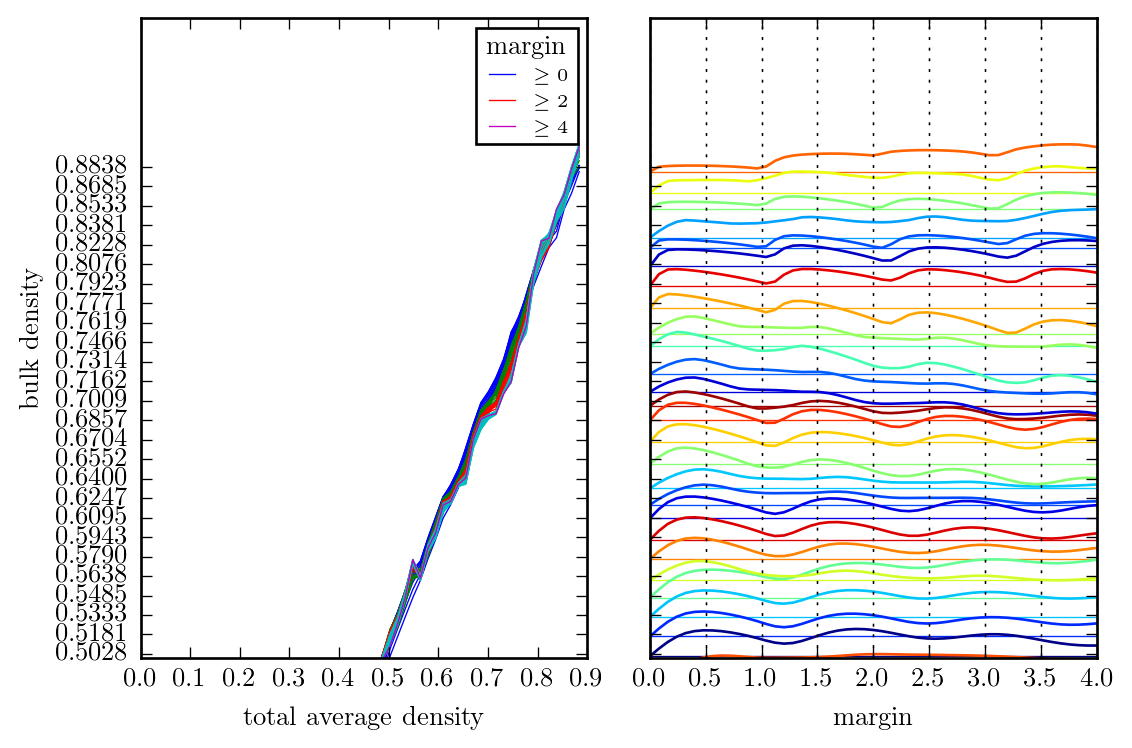

In [48]:
# Plot bulk densities with different margins
fig, (lax, rax) = plt.subplots(ncols=2, sharey=True)
total_dens = ns/N
for margin in margins:
    lax.plot(total_dens, densities[margin], lw=0.5, label='{:.1g}'.format(margin),
             color=('bgrcmyk'*2)[int(margin)])
for densities_row in densitieses.T:
    rax.plot(margins, densities_row, color=cm.jet(densities_row[0]*10 % 1))
try:
    rax.hlines(densities[0], margins.min(), margins.max(), lw=0.5,
               #colors=('bgrcmyk'*int(len(densities[0])//7 + 1))[:len(densities[0])]
               colors=cm.jet(densities[0]*10 % 1)
              )
except KeyError:
    print 'nope'
rax.grid(True, axis='x', which='both')
rax.set_xticks(np.arange(margins.min(), margins.max(), 0.5), minor=True)

handles, labels = map(np.array, lax.get_legend_handles_labels())
hl_ind = margins == margins.astype('i')
lax.legend(handles[hl_ind], map(r'$\ge{}$'.format, [l for l in labels[hl_ind]]),
           loc='best', title='margin', fontsize='x-small')
lax.set_xlabel('total average density')
lax.set_ylabel('bulk density')
lax.set_yticks(ns/N)
lax.set_ylim(0.50, 1.00)
#rax.legend(total_dens.astype('S3'), loc='best', title='total average density', fontsize='x-small')
rax.set_xlabel('margin')

In [15]:
margin = 2
dmin, dmax = densities[margin].min(), densities[margin].max()
print dmin, dmax
col = lambda dens: cm.jet((dens - dmin)/(dmax - dmin))

0.0276404325066 0.877378022654


In [16]:
tracks.plot_msd(msads, msadids, dtau, dt0, data[omask]['f'].max()+1, S=1, fps=1, prefix=prefix
                , figsize=(16,15), show_tracks=False, meancol='k',lw=4, errorbars=20
                , xlim=None#(dtau/fps,64)
                , ylim=None#(3e-2, 3e2)
                , title='', tnormalize=0
                , kill_flats=0.03
                , kill_jumps=.9
                , save='')#savedir+prefix+'_MSD.pdf')

NameError: name 'msads' is not defined

# Translational MSDs

In [17]:
def diff_const(taus, msd, tau_start=None, tau_end=None,
               msd_err=None, fit=True, nargs=1):
    if tau_start == 'min': tau_start = np.argmin(msd/taus)
    if tau_end  ==  'min': tau_end  =  np.argmin(msd/taus)
    start = np.searchsorted(taus, tau_start) if tau_start else None
    end = np.searchsorted(taus, tau_end) if tau_end else None
    if fit:
        return curve_fit(powerlaw, taus[start:end], msd[start:end],
                         [1]*nargs, msd_err[start:end], True)
    else:
        mt = msd[start:end]/taus[start:end]
        w = 1/msd_err[start:end] if msd_err is not None else None
        d  = np.average(mt, weights=w)
        dd = np.average((mt - d)**2, weights=w)
        return d, dd

def powerlaw(t, d, b=1, c=0):
    """
    params:
    d prefactor
    b exponent
    c offset
    """
    return c + d * np.power(t, b)

def chained_power(t, d1, d2, b1=1, b2=1, c1=0, c2=0, ret_crossover=False):
    p1 = powerlaw(t, d1, b1, c1)
    p2 = powerlaw(t, d2, b2, c2)
    cp = np.maximum(p1, p2)
    if ret_crossover:
        ct = t[np.abs(p1-p2).argmin()]
        print ct
        ct = np.power(d1/d2, np.reciprocal(b2-b1))
        print ct
        return cp, ct
    else:
        return cp

def cage_time(taus, msd, msd_err=None):
    nargs = 3 # 2 for prefactor, 2 more for exponent.
              # 1 for exponent (nargs=3) forces one section to be diffusive.
    cpopt, cpcov = curve_fit(chained_power, taus, msd, [1]*nargs, msd_err)
    d1, d2, b1 = cpopt
    ct = np.power(d1/d2, np.reciprocal((b2 if nargs > 3 else 1)-b1))
    return cpopt, ct

In [18]:
# densities with good translational _and_ angular diffusive behavior
# for looking at MSD, MSAD simultaneously
ns_AT = np.setdiff1d(ns_all[ns_all<370], [296,328,344,352])
ni_AT = np.searchsorted(ns_all, ns_AT)
dens_AT = densities[margin][ni_AT]

In [19]:
if True:
    # load all averaged MSDS
    MSDS = np.load(locdir + "MSDS.npz")
else:
    # calculate average of all MSDS
    MSDS = {}
    # Calculate the MSDS 
    # Translational kill thresholds:
    kill_flats = defaultdict(lambda: 0.5, # units are pixels
                        { 16: 1, 32: 3, 48: 1, 64: 0.5, 80: 1, 96: 0.2, 112: 0.7,
                         128: 0.6, 144: 1, 160: 10, 176: 1, 192: 0.4, 336: 1,
                         360: 0.1, 368: .6, 400: 0.2, 464: 0.2 })
    kill_jumps = defaultdict(lambda: 100, {})
    for n in ns_all:
        prefix = 'n{:03d}'.format(n)
        msdnpz = np.load(locdir+prefix+"_MSD.npz")
        msds = msdnpz['msds']
        if 'dt0' in msdnpz.keys():
            dt0  = msdnpz['dt0'][()] # [()] gets element from 0D array
            dtau = msdnpz['dtau'][()]
        else:
            print "assuming dt0 = dtau = 10" # ok for before dt* was saved
            dt0  = 10
            dtau = 10
        print "averaging track MSDs"
        nframes = max([np.array(msd)[:,0].max() for msd in msds]) + 1
        taus = np.arange(dtau, nframes, dtau)
        taus, msd, msd_err = tracks.mean_msd(msds, taus, errorbars=True,
                                kill_flats=kill_flats[n],
                                kill_jumps=kill_jumps[n])
        MSDS[str(n)] = np.row_stack([taus, msd, msd_err])

In [20]:
ns_T = np.asarray(MSDS.files, int); ns_T.sort()
ni_T = np.searchsorted(ns_all, ns_T)
dens_T = densities[margin][ni_T]
ns_T

array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
       224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
       344, 352, 360, 368])

In [23]:
fps

120

In [21]:
# find coeffient of diffusion
ds, bs, ctopts, cts, dds, dbs = [],[],[],[],[],[]
for n in ns_T:
    taus, msd, msd_err = MSDS[str(n)] / [[fps/freq], [A], [A]]
    tau_start = 10
    tau_end   = None
    d, dd = diff_const(taus, msd, tau_start, tau_end, msd_err, fit=True)
    ctopt, ct = cage_time(taus, msd, msd_err)
    if len(np.atleast_1d(d)) > 1:
        d, b = d
        dd, db = np.diag(dd)
        bs.append(b)
        dbs.append(db)
    ds.append(d)
    dds.append(dd)
    ctopts.append(ctopt)
    cts.append(ct)
ds = np.squeeze(ds)
dds = np.squeeze(dds)
if bs:
    bs = np.squeeze(bs)
    dbs = np.squeeze(dbs)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(0, 50)

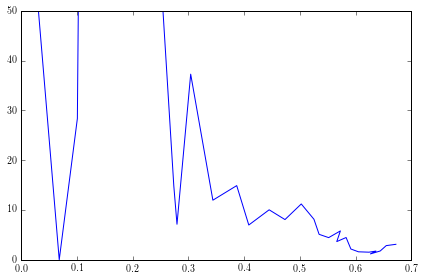

In [144]:
plt.plot(dens_T, cts)
plt.ylim(0,50)

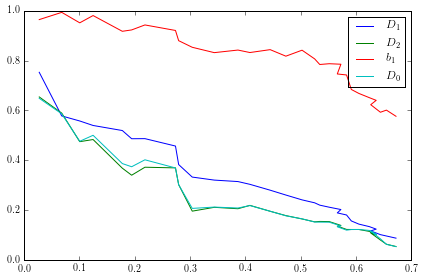

In [146]:
plt.plot(dens_T, ctopts)
plt.plot(dens_T, ds)
plt.legend(['$D_1$','$D_2$','$b_1$', '$D_0$'])

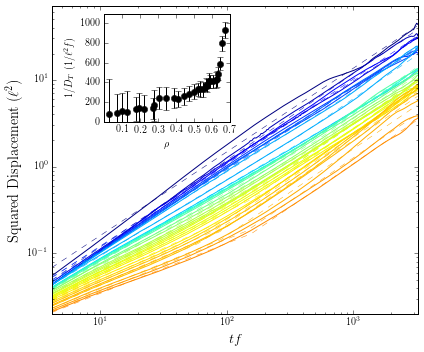

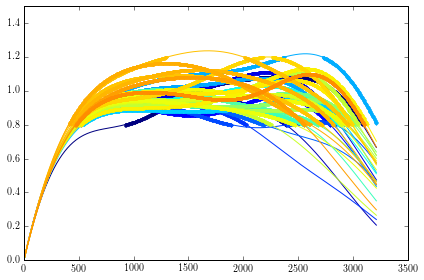

In [60]:
# Plot MSD and fits
save = True
tn = 0 # divide out this many powers of tau
flip = True # plot 1/D instead of D

rc('text', usetex=save)#save
dsd = 0**2 / A # uncert in squared disp (in pixels)
fig = plt.figure(figsize=(6,5))# if save else (14,10))
main = plt.gca()
inset = plt.axes([.25,.65,.29,.3])
mp = main
dp = inset
plt.figure()
for n, d, ctopt, ct in zip(ns_T, ds, ctopts, cts):
    taus, msd, msd_err = MSDS[str(n)] / [[fps], [A], [A]]
    dens = density[margin][n]
    c = col(dens)
    mp.plot(taus*freq, (msd-dsd)/taus**tn, c=c, label=format(dens, '.3f'))
    #mp.plot(taus*freq, powerlaw(taus, d)/taus**tn,
    #        '--', lw=.5, c=c)
    mp.plot(taus*freq, chained_power(taus, *ctopt)/taus**tn,
            '--', lw=.5, c=c)
    # Dots at elbows:
    #mp.plot(ct*freq, chained_power(ct, *ctopt)/ct**tn,
    #        'o', c=c, mec='none')
    llx, lls = helpy.loglog_slope(taus*freq, gaussian_filter(msd, 100, mode='nearest'))
    plt.plot(llx, lls, c=c)
    diffusive = np.abs(lls-1) < .2
    plt.plot(llx[diffusive], lls[diffusive], '.', c=c)
    plt.ylim(0, 1.5)
    #plt.xscale('log')

    if False:#not save: 
        label_loc = (msd/taus).argmin()
        x = taus[label_loc]
        y = msd[label_loc] / x**tn
        mp.text(x, y, n, color=c)
# plot the first one, times three, to show 'slope=1' guideline
#plt.plot(taus, 3*powerlaw(taus, ds[0]), 'k--')#, lw=.5, c=col(density[margin][n]))
mp.set_yscale('log')
mp.set_xscale('log')
tunit = 'seconds' if fps>1 else 'image frames'
yunit = r'$\ell^2{0}$' if A>1 else '$pixels^2{0}$'
yunit = yunit.format((' / '+tunit) if tn else '')
ylabel = 'Squared Displacement{} ({})'.format(' / Time' if tn else '', yunit)
mp.set_xlabel('$tf$', fontsize='x-large')
#mp.set_xlabel(r'Time ({})'.format(tunit), fontsize='x-large')
mp.set_ylabel(ylabel, fontsize='x-large')
mp.set_xlim(dtau*freq/fps, taus[-1]*freq)
mp.set_ylim((.05, 1) if tn==1 else (.02,70))
#mp.legend(loc='lower right', ncol=3, frameon=False, fontsize='small')

D = ds/freq
if flip:
    D = np.reciprocal(D)
dp.errorbar(dens_T, D, D*np.sqrt(dds)*len(taus), fmt='o', label='D', color='k')
dp.set_ylim(0, (22*freq if flip else .85/freq))
dp.set_xticks(np.arange(.1,.8,.1))
dp.set_xlabel(r'$\rho$')
dp.set_ylabel('${0}D_T$ ({0}{1})'.format('1/'*flip, r'$\ell^2f$'))
if save:
    savename = savedir + "MSD{}vN.pdf".format('_t'*tn)
    # = locdir+"MSDvN_dt0=%d_dtau=%d.png"%(dt0,dtau)
    # = locdir + "MSDvN_dsd=%d.png"%dsd
    fig.savefig(savename)

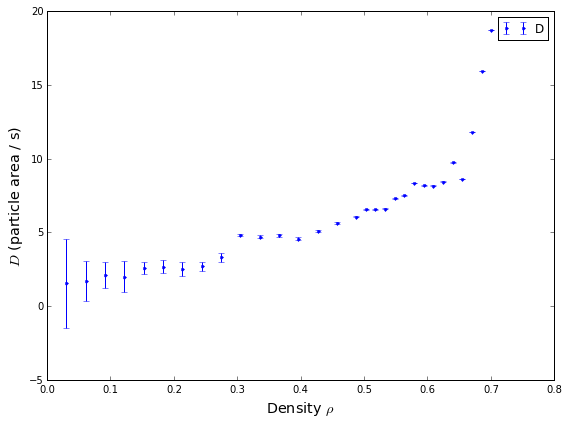

In [41]:
plt.figure(figsize=(8,6))
if bs:
    plt.errorbar(dens_T, bs, np.sqrt(dbs), fmt='.', label='b')
plt.errorbar(dens_T, 1/ds, np.sqrt(dds)*len(taus)*ds, fmt='.', label='D')
#plt.title("Constant of diffusion vs. density")
plt.xlabel(r"Density $\rho$", fontsize='x-large')
unit = '(particle area'
plt.ylabel("$D$ "+(unit+' / s)' if fps>1 else r"$pix^2/frame$"), fontsize='x-large')
#plt.ylim(0, 1)#np.max(ds)*1.2)
#plt.gca().set_yscale('log')
plt.legend(loc='best')
#plt.savefig(locdir+"DvN.pdf")#"DvN_dt0=%d_dtau=%d.png"%(dt0,dtau))

# Angular MSDs

In [36]:
if True:
    # load all averaged MSADS
    MSADS = np.load(locdir + "MSADS.npz")
else:
    # calculate average of all MSADS
    MSADS = {}
    # Angular:
    kill_flats = defaultdict(lambda: 0, {48: 5, 344: 0.03})
    kill_jumps = defaultdict(lambda: 1,
                    {16: 10, 32: 5, 48: 1, 64: 2, 80: 1, 96: 1, 344: .5, 448: 0.1,
                     456: 0.1, 464: 0.1})
    for n in ns_A:
        prefix = 'n{:03d}'.format(n)
        msadnpz = np.load(locdir+prefix+"_MSAD.npz")
        msads = msadnpz['msds']
        if 'dt0' in msadnpz.keys():
            dt0  = msadnpz['dt0'][()] # [()] gets element from 0D array
            dtau = msadnpz['dtau'][()]
        else:
            print "assuming dt0 = dtau = 10" #  should be true for all from before dt* was saved
            dt0  = 10
            dtau = 10
        print "averaging track MSADs"
        nframes = max([np.array(msad)[:,0].max() for msad in msads]) + 1
        taus = np.arange(dtau, nframes, dtau)
        taus, msad, msad_err = tracks.mean_msd(msads, taus, errorbars=True,
                                kill_flats=kill_flats[n],
                                kill_jumps=kill_jumps[n])
        MSADS[str(n)] = np.row_stack([taus, msad, msad_err])

In [37]:
ns_A = np.asarray(MSADS.files, int); ns_A.sort()
ni_A = np.searchsorted(ns_all, ns_A)
dens_A = densities[margin][ni_A]
ns_A

array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
       224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
       344, 352, 360, 368])

In [38]:
# find coeffient of angular diffusion
das, bas, ddas, dbas = [], [], [], []
for n in ns_A:
    taus, msad, msad_err = MSADS[str(n)]
    tau_start = None
    tau_end   = 2
    d, dd = diff_const(taus/fps, msad, tau_start, tau_end, msd_err, fit=True)
    if len(np.atleast_1d(d)) > 1:
        d, b = d
        dd, db = np.diag(dd)
        bas.append(b)
        dbas.append(db)
    das.append(d)
    ddas.append(dd)
das = np.squeeze(das)
ddas = np.squeeze(ddas)
if bas:
    bas = np.squeeze(bas)
    dbas = np.squeeze(dbas)

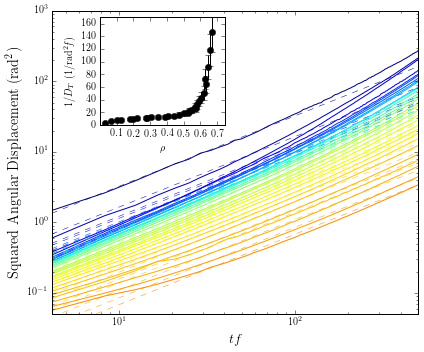

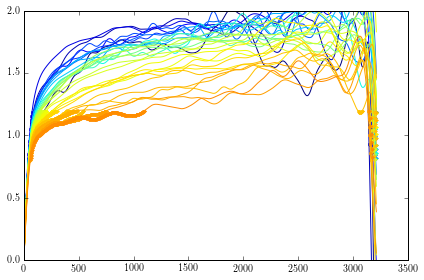

In [59]:
# Plot MSAD and fits
save = True
tn = 0 # divide out this many powers of tau
flip = True # plot 1/D instead of D

rc('text', usetex=save)
dsd = 0**2 # uncert in squared disp (in radians)
fig = plt.figure(figsize=(6,5) if save else (14,10))
main = plt.gca()
inset = plt.axes([.24,.64,.29,.3])
mp = main
dp = inset
plt.figure()
for n, d in zip(ns_A, das):
    taus, msd, msd_err = MSADS[str(n)]
    taus = taus/fps
    c = col(density[margin][n])
    mp.plot(taus*freq, (msd-dsd)/taus**tn, c=c)
    mp.plot(taus*freq, powerlaw(taus, d)/taus**tn,
             '--', lw=.5, c=c)
    llx, lls = helpy.loglog_slope(taus*freq, gaussian_filter(msd, 10, mode='nearest'))
    plt.plot(llx, lls, c=c)
    diffusive = np.abs(lls-1) < .2
    plt.plot(llx[diffusive], lls[diffusive], '.', c=c)
    plt.ylim(0,2)
    if False:#not save: 
        label_loc = (msd/taus).argmin()
        x = taus[label_loc]
        y = msd[label_loc] / x**tn
        mp.text(x, y, n, color=c)
# plot the first one, times three, to show 'slope=1' guideline
#plt.plot(taus, 3*powerlaw(taus, ds[0]), 'k--')#, lw=.5, c=col(density[margin][n]))
mp.set_yscale('log')
mp.set_xscale('log')
tunit = 'seconds' if fps>1 else 'image frames'
yunit = 'rad$^2{0}$' if A>1 else '$pixels^2{0}$'
yunit = yunit.format((' / '+tunit) if tn else '')
ylabel = 'Squared Angular Displacement{} ({})'.format(' / Time' if tn else '', yunit)
#mp.set_xlabel(r'Time ({})'.format(tunit), fontsize='x-large')
mp.set_xlabel('$tf$', fontsize='x-large')
mp.set_ylabel(ylabel, fontsize='x-large')

crop_time = True
mp.set_xlim(dtau*freq/fps, 500 if crop_time else taus[-1]*freq)
mp.set_ylim((.2, 200) if tn else (.05, 1e3 if crop_time else 9e3))

D = das/freq
if flip:
    D = np.reciprocal(D)
dp.errorbar(dens_A, D, D*np.sqrt(ddas)*len(taus), fmt='o', label='D_R', color='k')
dp.set_xlim(0, .75)
dp.set_ylim(0, (3.4*freq if flip else 18/freq))
dp.set_xticks(np.arange(.1, .8, .1))
#dp.set_yticks(dp.get_yticks()[:-1])

if save:
    dp.set_xlabel(r'$\rho$')
    #dp.set_ylabel('${0}D_R$ ({1}/{2})'.format('1/'*flip, *['rad$^2$', 'sec'][::-1 if flip else 1]))
    dp.set_ylabel('${0}D_T$ ({0}{1})'.format('1/'*flip, r'rad$^2f$'))

    savename = savedir + "MSAD{}vN.pdf".format('_t'*tn)
    # = locdir+"MSADvN_dt0=%d_dtau=%d.png"%(dt0,dtau)
    # = locdir + "MSADvN_dsd=%d.png"%dsd
    fig.savefig(savename)

#Angular vs Translational diffusion

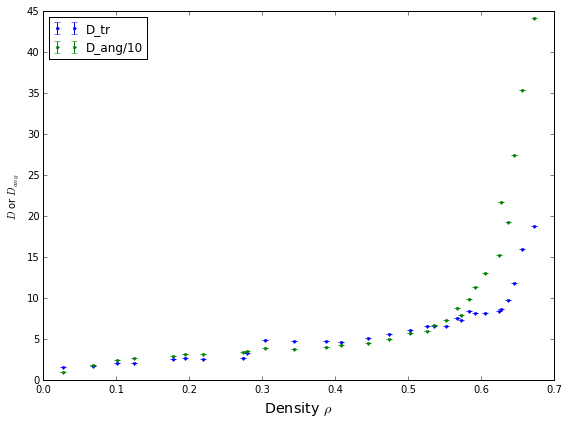

In [194]:
save = False
plt.figure(figsize=(8,6))
rc('text', usetex=save)
if bs:
    plt.errorbar(dens_T, bs, np.sqrt(dbs), fmt='.', label='b_T')
    plt.errorbar(dens_T, bas, np.sqrt(dbas), fmt='.', label='b_R')
plt.errorbar(dens_T, 1/ds, np.sqrt(dds), fmt='.', label='D_T')
plt.errorbar(dens_A, 15/das, np.sqrt(ddas), fmt='.', label='D_R/10')
plt.xlabel(r"Density $\rho$", fontsize='x-large')
plt.ylabel("$D$ or $D_R$")
#plt.ylim(0, None)#np.max(ds)*1.2)
plt.legend(loc='best')
if save: plt.savefig(savedir+'Ds.pdf')

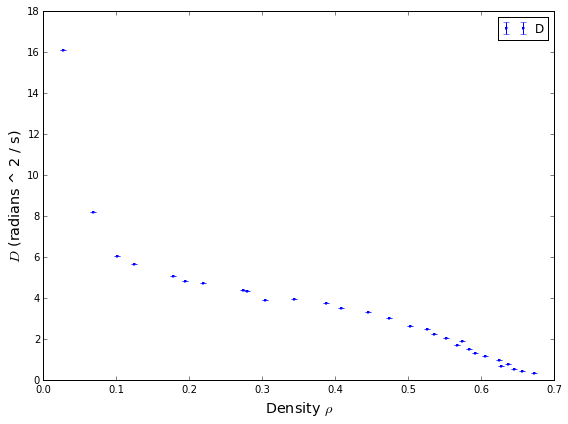

In [200]:
save = False
plt.figure(figsize=(8,6))
rc('text', usetex=save)
if bas: plt.errorbar(dens_A, bas, np.sqrt(dbas), fmt='.', label='b')
plt.errorbar(dens_A, das, np.sqrt(ddas)/fps, fmt='.', label='D', mec='none')
#plt.title("Constant of diffusion vs. density")
plt.xlabel(r"Density $\rho$", fontsize='x-large')
unit = '(radians ^ 2'
plt.ylabel("$D$ "+(unit+' / s)' if fps > 1 else unit+r"/frame)"), fontsize='x-large')
plt.ylim(0, None)#np.max(ds)*1.2)
#plt.gca().set_yscale('log')
plt.legend(loc='best')
if save: plt.savefig(locdir+"DAvN.pdf")#"DvN_dt0=%d_dtau=%d.png"%(dt0,dtau))

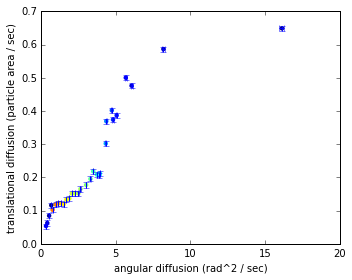

In [99]:
save = False
rc('text', usetex=save)
plt.figure(figsize=(5,4))
plt.errorbar(das, ds, np.sqrt(ddas*len(taus)), np.sqrt(dds*len(taus)), ls='', marker=',')
plt.scatter(das, ds, facecolor=col(dens_AT), lw=0)
plt.xlim(0, 20)
plt.ylim(0, .7)
plt.xlabel('angular diffusion (rad^2 / sec)')
plt.ylabel('translational diffusion (particle area / sec)')
if save: plt.savefig(savedir+'DvD.pdf')

In [147]:
np.intersect1d(ns_T, ns_A), ns_AT

(array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368]),
 array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 304, 312, 320, 336, 360, 368]))

In [79]:
diffusion_data = np.column_stack([ns, dens_A, ds[iT], das[iA], ratio])
names = lambda d: d.join('N rho DT DR DR_DT'.split())
np.savetxt('diffusion_coeffs.csv', diffusion_data, fmt='%.10f', delimiter=',', header=names(','))
np.savetxt('diffusion_coeffs.txt', diffusion_data, fmt='%.10f', header=names(' '*8))

In [78]:
'%.18e'%1.01

'1.010000000000000009e+00'

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368]
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368]
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368]
True True


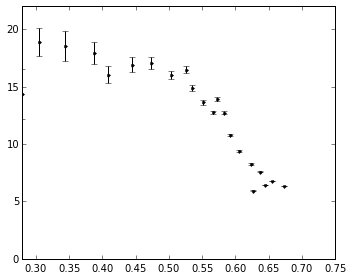

In [67]:
# Plot the Ratio of Diffusion Coefficients
# D_ratio = D_R / D_T
save = False
flip = False  # R/T unless flipped
rc('text', usetex=save)
plt.figure(figsize=(5,4))

ns = np.intersect1d(ns_T, ns_A)
iT = np.searchsorted(ns_T, ns)
iA = np.searchsorted(ns_A, ns)
ratio = das[iA]/ds[iT]
print np.allclose(das, das[iA]), np.allclose(ds, ds[iT])
if flip: ratio = 1/ratio
plt.errorbar(dens_A, ratio, ratio*np.sqrt((dds[iT]*das[iA]**2 + ddas[iA]*ds[iT]**2)*len(taus))
             , marker='.', ls='', color='k')
if save:
    order = -1 if flip else 1
    plt.ylabel('$D_{} / D_{}$ '.format(*[r'R', r'T'][::order]) +\
               '({}/{})$^2$'.format(*['rad',r'$\ell$'][::order]),
               fontsize='x-large')
    plt.xlabel(r'$\rho$', fontsize='x-large')
plt.ylim((0,.2) if flip else (1, 22))
plt.xlim(.28, .74)
plt.xticks(np.arange(.3, .8, .05))
plt.yticks(range(0,25,5))
if save: plt.savefig(savedir + "D_ratio.pdf")

In [51]:
dens_A

array([ 0.02764043,  0.06832481,  0.1008674 ,  0.12498956,  0.17784829,
        0.19468996,  0.21869648,  0.27390725,  0.2796322 ,  0.30421111,
        0.34403163,  0.38680743,  0.40847626,  0.44501945,  0.47343157,
        0.50264978,  0.5254233 ,  0.53467287,  0.55179867,  0.57286235,
        0.56637003,  0.58311168,  0.59169514,  0.60530127,  0.62410886,
        0.63667411,  0.62679231,  0.6443082 ,  0.65514424,  0.6724457 ])

# Angle-position Correlation $\langle \vec r \hat n \rangle$

In [202]:
np.count_nonzero(np.bincount(trackids) >= 7000)

456

In [87]:
# Build up data dicts by track for all datasets
#alltracksets = {}
#allotracksets = {}
for n in ns_all[::5]:
    if n in alltracksets and n in allotracksets: continue
    data, tracksets, odata, otracksets = loadall(n, ret_msd=False)
    alltracksets[n] = tracksets
    allotracksets[n] = otracksets

In [128]:
# Calculate all <rn> correlations
# That is, <x cos(phi)> and <y sin(phi)>
#alloxcorr = {}
#alloycorr = {}
corr_args = {'side': 'both', 'ret_dx': True, 'cumulant': True}
for n in [16, 96, 256, 376, 416, 456]:
    #if n in alloxcorr and n in alloycorr: continue
    print "{:3d}, {:5.1%}".format(n, density[2][n]),
    tracksets  = alltracksets[n]
    otracksets = allotracksets[n]
    #print [track for track in tracksets.keys()]
    #print [len(tracksets[track]) for track in tracksets.keys()]
    alloxcorr[n] = {track: corr.crosscorr(tracksets[track]['x']/S,
                                               np.cos(4*otracksets[track]), **corr_args)
                         for track in tracksets.keys() if len(tracksets[track]) >= 1000}
    alloycorr[n] = {track: corr.crosscorr(tracksets[track]['y']/S,
                                               np.sin(4*otracksets[track]), **corr_args)
                         for track in tracksets.keys() if len(tracksets[track]) >= 1000}
    print "... done!"

  16,  2.8% ... done!
 96, 19.5% ... done!
256, 50.3% ... done!
376, 68.5% ... done!
416, 76.3% ... done!
456, 85.7% ... done!


In [207]:
#Save the <rn> correlations
alloxcorr[96][1]

(array([-3850, -3849, -3848, ...,  3847,  3848,  3849]),
 array([ 0.00814488,  0.00855668,  0.00838561, ...,  0.01607229,
         0.015782  ,  0.01552884]))

<type 'numpy.ndarray'>
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.0241697884401
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.00637683269532
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.0130753748315
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.078832903545
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.00206405691787
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): -0.0415764405996


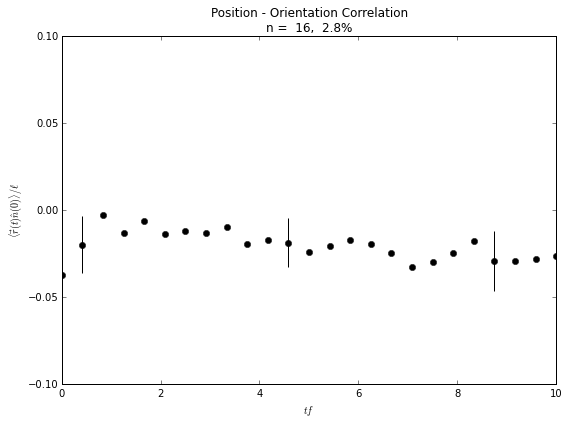

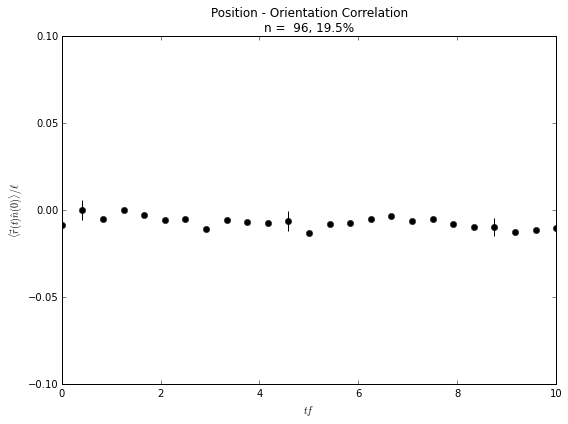

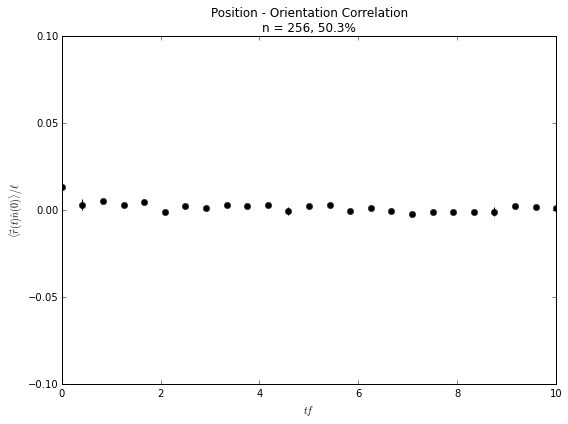

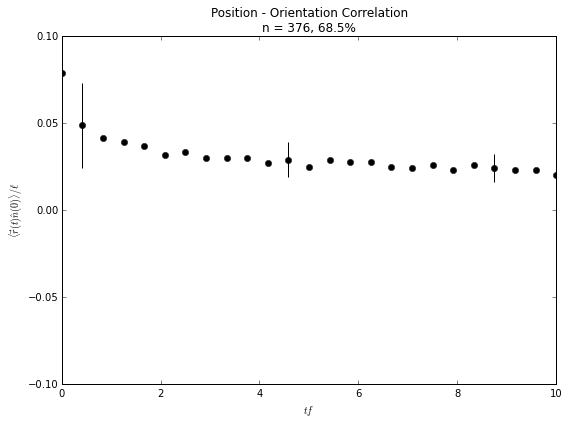

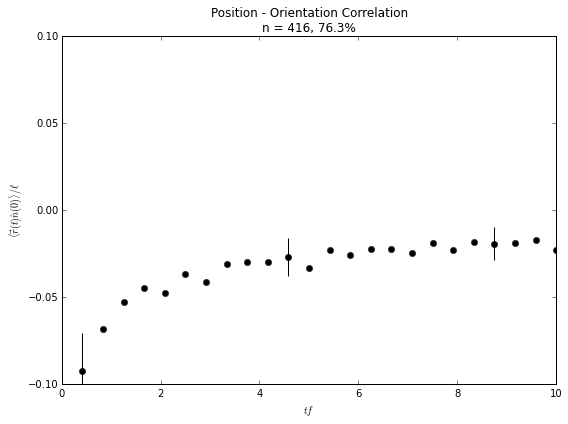

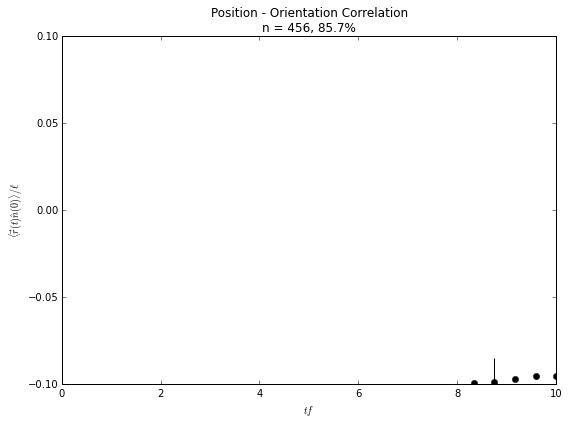

In [146]:
# Average, Fit and plot <rn> correlation
do_fit = False
save = False
rc('text', usetex=save)
print type(allcorr)
nframes = 200
tcorr = np.arange(nframes)*freq/fps
for n in sorted(alloxcorr):
    allcorr = []
    plt.figure(figsize=smallfig if save else largefig)
    prefix = n
    for track in allotracksets[prefix]:
        if len(allotracksets[prefix][track]) < 1000: continue
        tcorr = alloxcorr[prefix][track][0]
        index = np.abs(tcorr) < nframes
        oxcorr = alloxcorr[prefix][track][1][index]
        oycorr = alloycorr[prefix][track][1][index]
        tcorr = tcorr[index]*freq/fps
        allcorr.append(oxcorr)
        allcorr.append(oycorr)
        #plt.plot(tcorr, oxcorr, 'g', alpha=.25)
        #plt.plot(tcorr, oycorr, 'b', alpha=.25)
    allcorr = helpy.pad_uneven(allcorr)
    meancorr = np.nanmean(allcorr, 0)
    errcorr = np.nanstd(allcorr, 0)/sqrt(len(allcorr))
    err_offset = np.abs(errcorr.mean())
    tmin, tmax = 0 if corr_args['side']=='right' else 0, 0 if corr_args['side']=='left' else 10
    print tcorr.shape, meancorr.shape, errcorr.shape
    plt.errorbar(tcorr, meancorr, errcorr, None, 'ok', capthick=0, elinewidth=1, errorevery=10)
    xlims = max(tmin, tcorr.min()), min(tmax, tcorr.max())
    print "bounds:", tmin, tmax
    print "trange:", tcorr.min(), tcorr.max(), tcorr.shape
    print "tlims: ", xlims[0], xlims[1]
    plt.xlim(*xlims)
    #plt.ylim(1e-2, 2)

    print 'max corr (approx v0/D_R):', meancorr.max()

    if do_fit:
        fmin = np.searchsorted(tcorr, 0)
        fmax = np.searchsorted(tcorr, tmax)
        print 'flims: ', fmin, fmax
        print 'fitlims: ', tcorr[fmin], tcorr[fmax]
        fitform = corr.powerlaw
        #fitform = lambda s, v_D, dx0=0, D=D_R: v_D*(1 - corr.exp_decay(s-dx0, 1/D))
        p0 = [1, 1]
        popt, pcov = curve_fit(fitform, tcorr[fmin:fmax], meancorr[fmin:fmax],
                               p0=p0, sigma=err_offset + errcorr[fmin:fmax]
                               )
        print "\nFits:"
        print '\n'.join(['time: {:.1f}', 'amp: {:.3f}', 'offset: {:.3f}'][:len(popt)]).format(*popt)
        fit = fitform(tcorr, *popt)
        plt.plot(tcorr, fit, 'r', lw=2,
                     label='$t_0$: {:.3f}, $A$: {:.3f}'.format(*popt)
                    )
        pguess = {
                 16: (1, 0),
                 96: (1, 0),
                 256:(1, 0),
                 376:(1,.2),
                 416:(2,.4),
                 456:(2,.5),
        }
        #guess = fitform(tcorr, *pguess[n])
        #plt.plot(tcorr, guess, 'y', lw=2,
        #             label=r'$A e^{t/t_0}$'+'\n'+
        #                    '$t_0$: {:.3f}, $A$: {:.3f}'.format(*pguess[n])
        #            )
    plt.ylim(-.1, .1)
    plt.xlim(*xlims)
    #plt.yscale('log'); plt.ylim(1e-3,.5)
    #plt.xscale('log'); plt.xlim(1, xlims[1])
    plt.title("Position - Orientation Correlation\n"
              "n = {:3d}, {:5.1%}".format(n, density[2][n]))
    plt.ylabel(r"$\langle \vec r(t) \hat n(0) \rangle / \ell$")
    plt.xlabel("$tf$")
    plt.legend(loc=0, framealpha=1)

#Tracks

In [ ]:
nframes = data['f'].max() + 1
nframeso = data['f'][omask].max() + 1

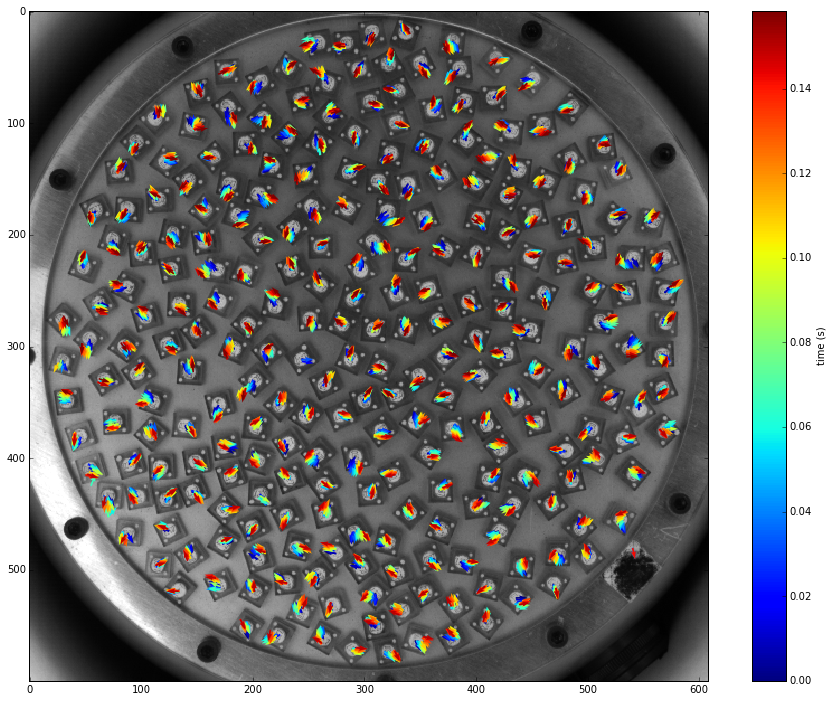

(<matplotlib.quiver.Quiver at 0x10baf63d0>,
 <matplotlib.colorbar.ColorbarBase instance at 0x10baf3f80>)

In [8]:
orient.plot_orient_quiver(data[:5000], odata[:5000], omask[:5000], imfile=locdir+prefix+'_0001.tif', fps=120,
                          figsize=(16,12), savename='')#savedir + 'quiver_tracks.png')

tracks used are set([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34])


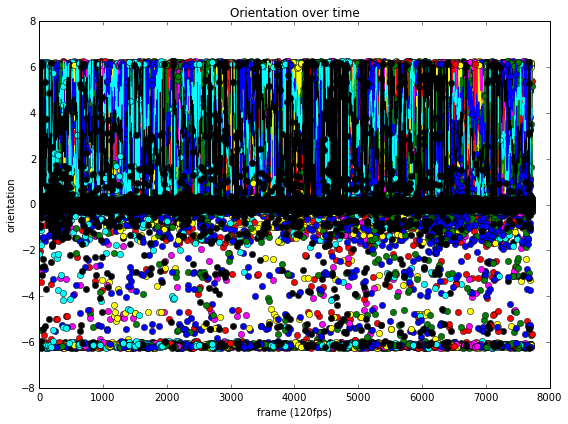

In [7]:
orient.plot_orient_time(data,odata,trackids,delta=True)#,simplify=True)

tracks used are set([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34])


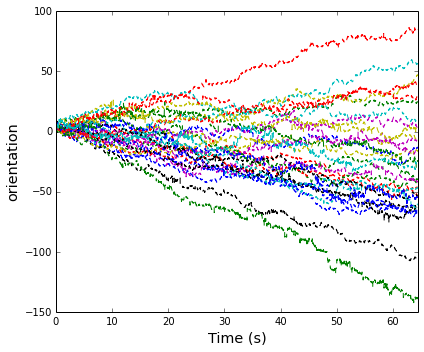

In [151]:
orient.plot_orient_time(data, odata, trackids, fps=fps, delta=False, save='savedir' + orient_tracking.pdf')

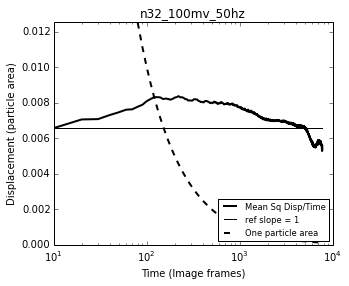

In [92]:
tracks.plot_msd(msds, msdids, dtau, dt0, nframes, prefix=prefix, tnormalize=1)

using dtau = 10, dt0 = 10
Rough coefficient of diffusion: 8.14727780692
Rough diffusion timescale: 0.166666666667
saving to /Users/leewalsh/Physics/Squares/writing/graphics/MSAD.pdf


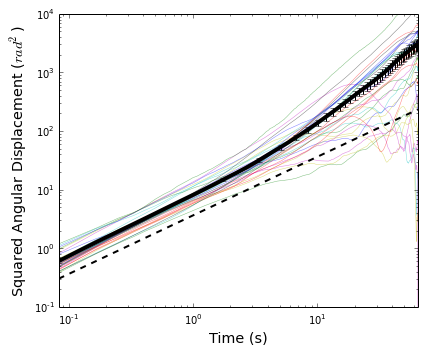

(array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
         120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
         230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
         340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
         450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
         560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
         670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
         780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
         890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
        1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
        1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
        1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
        1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
        1440, 1450, 1460, 1470, 1480, 

In [237]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, prefix=prefix, errorbars=20,
                 fps=fps, S=S, ang=True, show_tracks=True, figsize=(6,5), meancol='k', title="", lw=4,
                 xlim=(dtau/fps, 64), ylim=(1e-1,1e4), save=savedir + 'MSAD.pdf')

using dtau = 10, dt0 = 10
Rough coefficient of diffusion: 8.14727780692
Rough diffusion timescale: 0.166666666667
saving to ../writing/graphics/MSAD.pdf


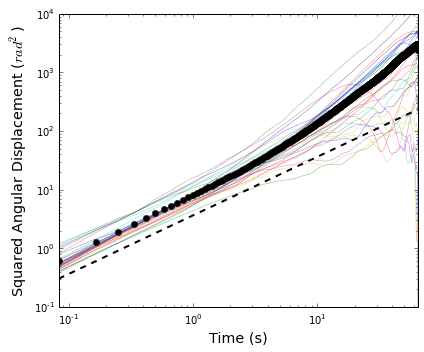

In [146]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, prefix=prefix,
                 fps=fps, S=S, ang=True, show_tracks=True, figsize=(6,5), meancol='k', title="",
                 xlim=(dtau/fps, 64), ylim=(1e-1,1e4), save='')#savedir + 'MSAD.pdf')

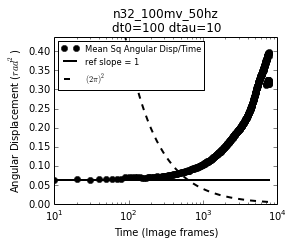

In [89]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, tnormalize=1, ang=True, prefix=prefix, show_tracks=False)

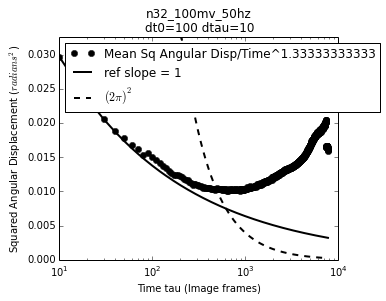

In [47]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, tnormalize=4./3, ang=True, prefix=prefix, show_tracks=False)

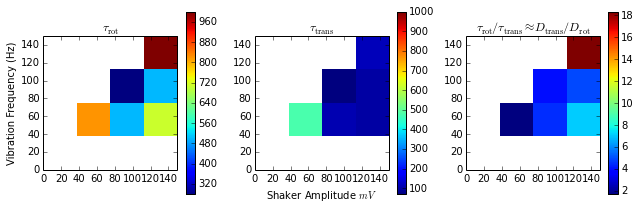

In [165]:
tau_trans = np.array([[ np.nan, np.nan, np.nan, np.nan],
                      [ np.nan, 480.,     110.,   100.],
                      [ np.nan, np.nan,    70.,   100.],
                      [ np.nan, np.nan, np.nan,   120.]])

tau_rot = np.array([[ np.nan, np.nan, np.nan, np.nan],
                    [ np.nan,   820.,   500.,   710.],
                    [ np.nan, np.nan,   280.,   500.],
                    [ np.nan, np.nan, np.nan,  2200.]])

plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(tau_rot,origin='lower',extent=(0,150,0,150),interpolation='nearest',vmax=1000.)
plt.title(r"$\tau_\mathrm{rot}$")
plt.ylabel('Vibration Frequency (Hz)')
plt.colorbar()
plt.subplot(132)
plt.imshow(tau_trans,origin='lower',extent=(0,150,0,150),interpolation='nearest',vmax=1000.)
plt.title(r"$\tau_\mathrm{trans}$")
plt.xlabel('Shaker Amplitude '+r'$mV$')
plt.colorbar()
plt.subplot(133)
plt.imshow(tau_rot/tau_trans,origin='lower',extent=(0,150,0,150),interpolation='nearest')
plt.title(r"$\tau_\mathrm{rot}/\tau_\mathrm{trans}\approx D_\mathrm{trans}/D_\mathrm{rot}$")
plt.colorbar()
plt.savefig(savedir + 'D_f_A.pdf')

#Order Parameters

In [60]:
ns_all, ns

(array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440,
        448, 456, 464]),
 array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440,
        448, 456, 464]))

In [21]:
freq = 50

In [22]:
if True:
    Phi_npz = np.load(locdir+'phi_t.npz')
    Phi = {n: Phi_npz[str(n)] for n in ns_all}
else:
    Phi = {}
    for n in ns_all:
        data, trackids, odata, omask = load_data(n)
        Phi[n] = np.array([corr.orient_op(o['orient'], d[['x','y']].view((float,2)).copy()
                                          , m=4, margin=2, ret_complex=False)
                  for d, o in it.izip(helpy.splitter(data[omask], data['f'][omask]),
                                      helpy.splitter(odata[omask], data['f'][omask]))])
    np.savez(locdir + 'phi_t.npz', **{str(n): Phi[n] for n in ns_all})

In [85]:
np.savetxt(locdir+'all_phi_t', np.column_stack([Phi[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

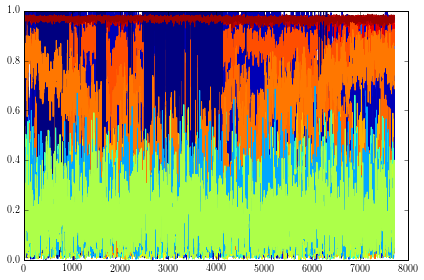

In [198]:
for n, P in reversed(Phi.items()):
    plt.plot(P, color=col(density[margin][n]))

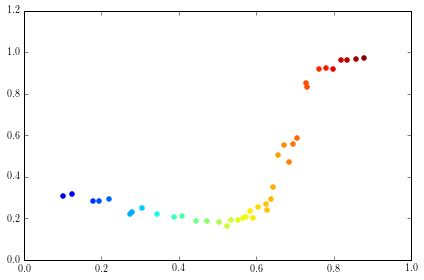

In [199]:
for n in ns_all:
    plt.scatter(density[margin][n], Phi[n].mean(), color=col(density[margin][n]))

In [23]:
nframes = len(Phi[16])

In [24]:
Phi_ac = {n: corr.autocorr(P) for n, P in Phi.iteritems()}

In [248]:
np.savetxt(locdir+'all_phiphi_newcorrfunc', np.column_stack([Phi_ac[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

In [269]:
# Fit to poly_exp
Phi_ac_pe = {}
for n, Pac in Phi_ac.iteritems():
    x = np.arange(len(Pac))
    if not np.all(np.isfinite(Pac)):
        print n, 'not all finite'
        continue
    try:
        p, _ = curve_fit(corr.poly_exp, x, Pac, [1,1,1])
        Phi_ac_pe[n] = corr.poly_exp(x, *p)
    except RuntimeError:
        continue

16 not all finite
32 not all finite


In [249]:
# Gaussian smooth (low-pass)
Phi_ac_lp = {}
for n, Pac in Phi_ac.iteritems():
    g = [gaussian_filter(Pac, sig, mode='constant', cval=Pac[sig]) for sig in (1, 10, 100, 1000)]
    Phi_ac_lp[n] = np.choose(np.repeat([0,1,2,3], [10,90,900,len(Pac)-1000]), g)

In [25]:
Phi_ac_vg = { n: corr.vary_gauss(Pac, .1*np.arange(len(Pac))+.001*np.arange(len(Pac))**2) for n, Pac in Phi_ac.iteritems()}

In [189]:
Phi_ac_vg_a = { n: corr.vary_gauss(Pac, .1*np.arange(len(Pac))+.001*np.arange(len(Pac))**2) for n, Pac in Phi_ac.iteritems()}

In [190]:
Phi_ac_vg_b = { n: corr.vary_gauss(Pac, (0, .1, .001)) for n, Pac in Phi_ac.iteritems()}

In [260]:
Phi_ac_vg_c = { n: corr.vary_gauss(Pac, (0, .1, .0002)) for n, Pac in Phi_ac.iteritems()}

In [264]:
Phi_ac_vg_d = { n: corr.vary_gauss(Pac, (0, .2, .0002)) for n, Pac in Phi_ac.iteritems()}

In [266]:
Phi_ac_vg_e = { n: corr.vary_gauss(Pac, .1) for n, Pac in Phi_ac.iteritems()}

In [207]:
Phi_ac_vg_l = { n: corr.vary_gauss(Pac, (0, .1, .001)) for n, Pac in Phi_ac.iteritems()} # /len(ko)

In [210]:
Phi_ac_vg_1 = { n: corr.vary_gauss(Pac, (0, .1, .001)) for n, Pac in Phi_ac.iteritems()}

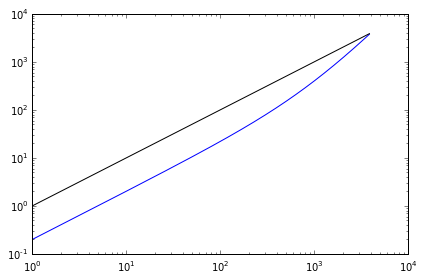

In [263]:
plt.loglog(poly.polyval(np.arange(3864), (0,.2,2e-4)))
plt.loglog(np.arange(3864), 'k')

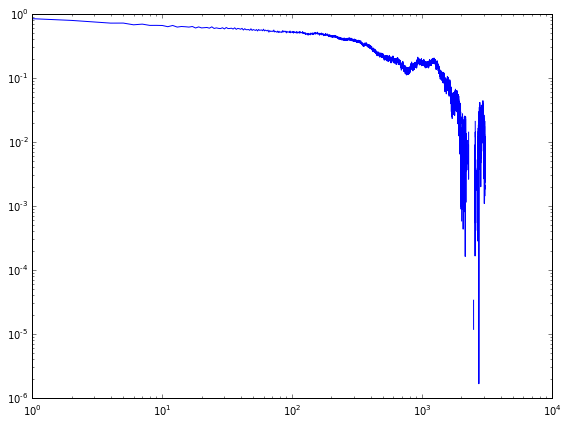

In [87]:
plt.figure(figsize=largefig)
plt.loglog(Phi_ac[n])

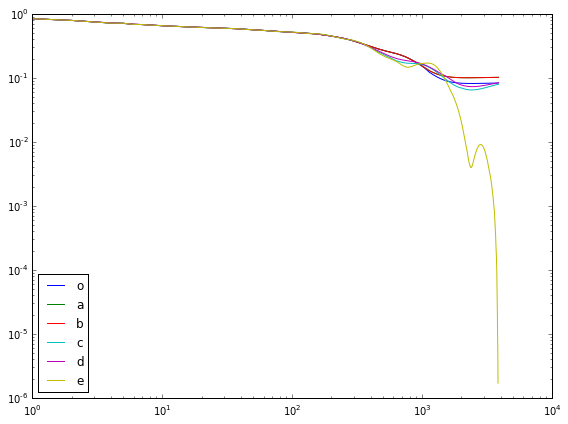

In [269]:
n = 416
plt.figure(figsize=largefig)
plt.loglog(np.column_stack([Phi_ac[n],
                            Phi_ac_vg[n],
                            Phi_ac_vg_a[n], Phi_ac_vg_b[n],
                            Phi_ac_vg_c[n], Phi_ac_vg_d[n],
                            Phi_ac_vg_e[n],
                           ]))
plt.legend('o a b c d e'.split(), loc='best')
#plt.ylim(.06, .2)
#plt.xlim(100,None)

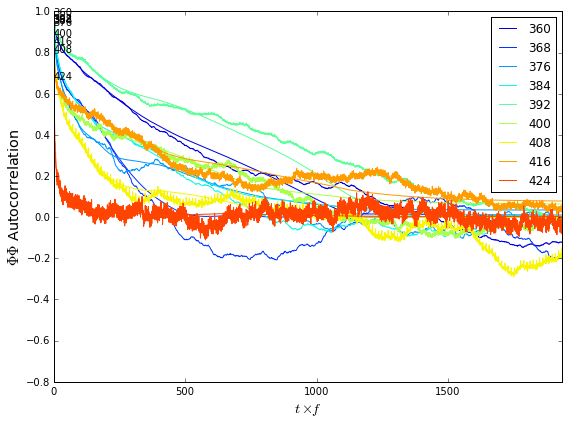

In [251]:
# Plot the Phi-Phi Autocorrelation
save = False
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
for n in [360, 368, 376, 384, 392, 400, 408, 416, 424]:
    Pac = Phi_ac[n]
    tf = np.arange(len(Pac))#*freq/fps
    try:
        plt.plot(tf, Phi_ac[n], color=col((n-350)/100), label=str(n))
        plt.plot(tf, np.maximum(Phi_ac_vg[n],0), color=col((n-350)/100))
        plt.text(tf[1],Phi_ac_vg[n][1], str(n)) 
    except KeyError:
        continue
    #plt.plot(tf, np.maximum(Pac,0), color=col(density[margin][n]), alpha=.8)
plt.legend(loc='best')
plt.yscale('linear')
plt.xscale('linear')
#plt.ylim(0, 1)
plt.xlim(freq/fps, nframes/4)
plt.ylabel(r'$\Phi\Phi$ Autocorrelation', fontsize='x-large')
plt.xlabel(r'$t\times f$', fontsize='x-large')
if save: plt.savefig(savedir + "phi_autocorr.pdf")

a, x0, sig = [  1.61997977e+02   7.02380592e-01   8.55275130e-02]


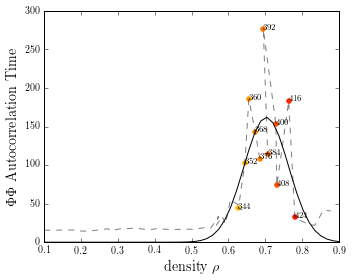

In [54]:
save = True
rc('text', usetex=save)
ns = ns_all

Phi_ac_fortime = Phi_ac
plt.figure(figsize=smallfig)
Phi_time = np.array([corr.decay_scale(Phi_ac_fortime[n], smooth='', method='int') for n in ns]) * freq/fps
for n, tau in zip(ns, Phi_time)[26:37]:
    plt.scatter(density[margin][n], tau, color=col(density[margin][n]))
    plt.text(density[margin][n], np.nan_to_num(tau), '{:d}'.format(n), fontsize='small')
plt.plot(densities[margin], Phi_time, 'k--', alpha=0.5)
p_phi, _ = curve_fit(gauss, densities[margin][np.isfinite(Phi_time)], Phi_time[np.isfinite(Phi_time)],
                     p0 = [100, .7, .2])
print 'a, x0, sig =', p_phi
plt.plot(np.linspace(0.1,0.9), gauss(np.linspace(0.1,0.9), *p_phi), 'k')
plt.xlim(.1,.9)
plt.ylim(0, None)
plt.xlabel(r'density $\rho$', fontsize='x-large')
plt.ylabel(r'$\Phi\Phi$ Autocorrelation Time', fontsize='x-large')
if save: plt.savefig(savedir+'phiphi_time.pdf')

In [32]:
if True:
    Psi_npz = np.load(locdir+'psi_t.npz')
    Psi = {n: Psi_npz[str(n)] for n in ns_all}
else:
    Psi = {}
    for n in ns_all:
        data, trackids, odata, omask = load_data(n)
        Psi[n] = np.array([corr.pair_angle_op(
                                   *corr.pair_angles(d[['x','y']].view((float,2)).copy(), 4,
                                                     margin=2, dub=2*S)[:2]
                           , m=4)[0]
                  for d, o in it.izip(helpy.splitter(data[omask], data['f'][omask]),
                                      helpy.splitter(odata[omask], data['f'][omask]))])
    np.savez(locdir + 'psi_t.npz', **{str(n): Psi[n] for n in ns_all})

In [88]:
np.savetxt(locdir+'all_psi_t', np.column_stack([Psi[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

In [33]:
Psi_ac = { n: corr.autocorr(P) for n, P in Psi.iteritems()}

In [254]:
np.column_stack([Phi_ac[n] for n in ns_all]).shape

(3864, 42)

In [255]:
np.savetxt(locdir+'all_psi_psi_newcorrfunc', np.column_stack([Psi_ac[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

In [215]:
# Gaussian smooth (low-pass)
Psi_ac_lp = {}
for n, Pac in Psi_ac.iteritems():
    g = [gaussian_filter(Pac, sig, mode='constant', cval=Pac[sig]) for sig in (1, 10, 100, 1000)]
    Psi_ac_lp[n] = np.choose(np.repeat([0,1,2,3], [10,90,900,len(Pac)-1000]), g)

In [34]:
Psi_ac_vg = { n: corr.vary_gauss(Pac, .2*np.arange(len(Pac))+.001*np.arange(len(Pac))**2)
             for n, Pac in Psi_ac.iteritems()}

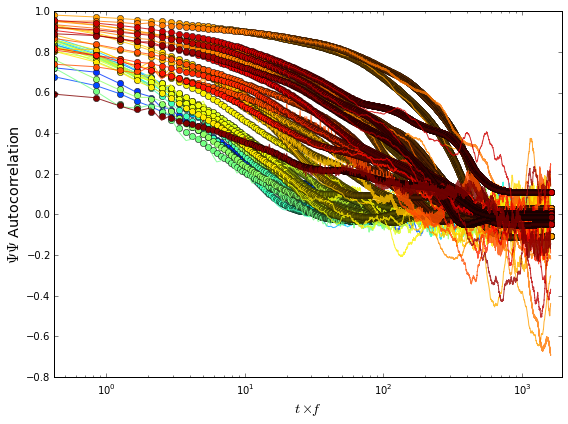

In [257]:
# Plot the Psi-Psi Autocorrelation
save = False
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
for n in ns_all:
    Pac = Psi_ac[n]
    tf = np.arange(len(Pac))*freq/fps
    plt.plot(tf, Psi_ac_vg[n], 'o', color=col(density[margin][n]))
    plt.plot(tf, Pac, color=col(density[margin][n]), alpha=.8)
plt.yscale('linear')
plt.xscale('log')
#plt.ylim(.1, 1)
plt.xlim(freq/fps, nframes/4)
plt.ylabel(r'$\Psi\Psi$ Autocorrelation', fontsize='x-large')
plt.xlabel(r'$t\times f$', fontsize='x-large')
if save: plt.savefig(savedir + "psi_autocorr.pdf")

a, x0, sig = [ 145.97203488    0.77059255    0.16774112]


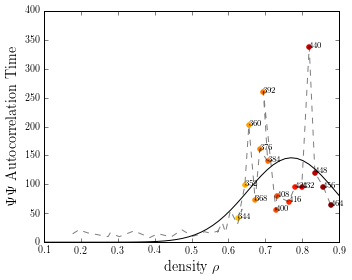

In [53]:
save = True
rc('text', usetex=save)

Psi_ac_fortime = Psi_ac_vg
plt.figure(figsize=smallfig)
ns = ns_all
Psi_time = np.array([corr.decay_scale(Psi_ac_fortime[n], smooth='', method='int') for n in ns]) * freq/fps
for n, tau in zip(ns, Psi_time)[26:]:
    plt.scatter(density[margin][n], tau, color=col(density[margin][n]))
    plt.text(density[margin][n], np.nan_to_num(tau), '{:d}'.format(n), fontsize='small')
plt.plot(densities[margin], Psi_time, 'k--', alpha=0.5)
p_psi, _ = curve_fit(gauss, densities[margin][np.isfinite(Psi_time)], Psi_time[np.isfinite(Psi_time)],
                     p0=[800, .7, .2])
print 'a, x0, sig =', p_psi
plt.plot(np.linspace(0.1,0.9), gauss(np.linspace(0.1,0.9), *p_psi), 'k')
plt.xlim(.1,.9)
plt.ylim(0, None)
plt.xlabel(r'density $\rho$', fontsize='x-large')
plt.ylabel(r'$\Psi\Psi$ Autocorrelation Time', fontsize='x-large')
if save: plt.savefig(savedir+'psipsi_time.pdf')

(0, 900.0)

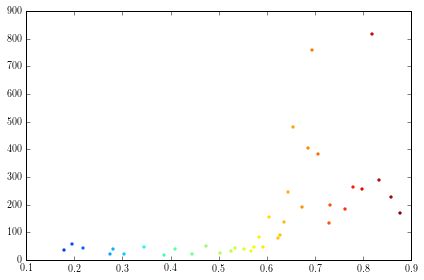

In [173]:
for n in ns_all:
    #tau_v = corr.decay_scale(Psi_ac_vg[n], tf, smooth='', method='inverse_mean', rectify=False)
    #tau_m = corr.decay_scale(np.maximum(Psi_ac_vg[n],0), tf, smooth='', method='mean', rectify=False)
    tau_i = corr.decay_scale(Psi_ac_vg[n], tf, smooth='', method='int', rectify=False)
    dens = density[margin][n]
    plt.scatter(dens, tau_i, marker='.', color=col(dens))
    #plt.scatter(dens, tau_m, marker='*', color=col(dens))
    #plt.scatter(dens, tau_v, marker='+', color=col(dens))    
plt.xlim(.1,.9)
plt.ylim(0, None)

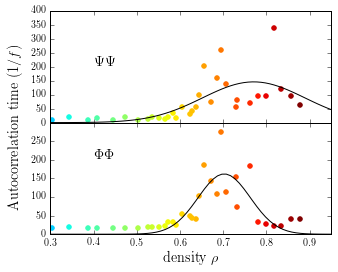

In [52]:
save = True
rc('text', usetex=True)
ns = ns_all
figsize = (smallfig[0]*1.5, smallfig[1])
fig = plt.figure(figsize=smallfig)
gs = gridspec.GridSpec(2,1)
gs.update(hspace=0, left=.12)
axt = fig.add_subplot(gs[0])
axb = fig.add_subplot(gs[1])
axphi = axb
axpsi = axt

Phi_time = np.array([corr.decay_scale(Phi_ac[n], smooth='', method='int') for n in ns]) * freq/fps
Psi_time = np.array([corr.decay_scale(Psi_ac_vg[n], smooth='', method='int') for n in ns]) * freq/fps
for n, tau in zip(ns, Phi_time):
    axphi.scatter(density[margin][n], tau, color=col(density[margin][n]))
for n, tau in zip(ns, Psi_time):
    axpsi.scatter(density[margin][n], tau, color=col(density[margin][n]))
#axphi.plot(densities[margin], Phi_time, 'k--', alpha=0.5)
#axpsi.plot(densities[margin], Psi_time, 'k--', alpha=0.5)
n_cont = np.linspace(0,1,100)
axphi.plot(n_cont, gauss(n_cont, *p_phi), 'k')
axpsi.plot(n_cont, gauss(n_cont, *p_psi), 'k')

axt.set_ylim(0, None)
axphi.text(0.4, 200, r'$\Phi\Phi$', fontsize='x-large')
axpsi.text(0.4, 200, r'$\Psi\Psi$', fontsize='x-large')
axt.set_xticklabels([])
axb.set_xlabel(r'density $\rho$', fontsize='x-large')  
xlim = (.3, .95)
axt.set_xlim(xlim)
axb.set_xlim(xlim)
axb.set_ylim(0, None)
axb.set_yticklabels(range(0,300,50))
fig.text(0, .75, "Autocorrelation time ($1/f$)", rotation='vertical', fontsize='x-large')
if save: plt.savefig(savedir+'autocorr_time.pdf')